In [1]:
import zipfile
import os, glob
import numpy as np
import nibabel as nib
from nibabel.processing import resample_from_to
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [2]:
def unzip_to_folder(zip_path):
    folder_name = os.path.splitext(os.path.basename(zip_path))[0]
    os.makedirs(folder_name, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder_name)
    print(f"Unzipped {zip_path} → {folder_name}/")
    return folder_name

In [3]:
unzip_to_folder("/content/Final_tvt_Dataset.zip")

Unzipped /content/Final_tvt_Dataset.zip → Final_tvt_Dataset/


'Final_tvt_Dataset'

Unison code with new prompt

In [4]:
import os
import pandas as pd

label_dir = "Final_tvt_Dataset/train/labels"
csv_path  = "/content/strat_subset.csv"

# 1) CSV with ID_num extracted: OAS1_0179_MR1 -> 0179
df = pd.read_csv(csv_path)
df["ID_num"] = df["ID"].str.split("_").str[1]

# 2) Label IDs from filenames (strip .nii/.nii.gz)
label_files = [f for f in os.listdir(label_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
label_ids = [f.split(".nii")[0] for f in label_files]   # yields '0179' etc.
label_ids_set = set(label_ids)

# 3) Filter CSV to only rows that have a label in train
train_csv = df[df["ID_num"].isin(label_ids_set)].copy()

print("All CSV unique ID_num:", df["ID_num"].nunique())
print("Train label IDs:", len(label_ids_set))
print("Filtered train_csv unique ID_num:", train_csv["ID_num"].nunique())
print("Filtered train_csv rows:", len(train_csv))

# 4) (Optional) Deduplicate to one row per subject id (keep MR1 if present, else first)
# This keeps a single row per ID_num so it aligns 1:1 with labels.
train_csv["_mr"] = df["ID"].str.split("_").str[-1]  # MR1/MR2
train_csv = (train_csv.sort_values(["ID_num", "_mr"])  # MR1 sorts before MR2
                      .drop_duplicates(subset="ID_num", keep="first")
                      .drop(columns=["_mr"]))

print("After dedupe -> one row per subject:")
print("  train_csv unique ID_num:", train_csv["ID_num"].nunique())
print("  rows:", len(train_csv))

# 5) Sanity check: the sets should now match (or show what's missing)
csv_ids = set(train_csv["ID_num"])
print("CSV minus labels (should be empty):", csv_ids - label_ids_set)
print("Labels minus CSV (should be empty):", label_ids_set - csv_ids)


All CSV unique ID_num: 104
Train label IDs: 81
Filtered train_csv unique ID_num: 81
Filtered train_csv rows: 81
After dedupe -> one row per subject:
  train_csv unique ID_num: 81
  rows: 81
CSV minus labels (should be empty): set()
Labels minus CSV (should be empty): set()


In [5]:
import os
import pandas as pd

label_dir = "Final_tvt_Dataset/val/labels"
csv_path  = "/content/strat_subset.csv"

# 1) CSV with ID_num extracted: OAS1_0179_MR1 -> 0179
df = pd.read_csv(csv_path)
df["ID_num"] = df["ID"].str.split("_").str[1]

# 2) Label IDs from filenames (strip .nii/.nii.gz)
label_files = [f for f in os.listdir(label_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
label_ids = [f.split(".nii")[0] for f in label_files]   # yields '0179' etc.
label_ids_set = set(label_ids)

# 3) Filter CSV to only rows that have a label in train
val_csv = df[df["ID_num"].isin(label_ids_set)].copy()

print("All CSV unique ID_num:", df["ID_num"].nunique())
print("Train label IDs:", len(label_ids_set))
print("Filtered train_csv unique ID_num:", val_csv["ID_num"].nunique())
print("Filtered train_csv rows:", len(val_csv))

# 4) (Optional) Deduplicate to one row per subject id (keep MR1 if present, else first)
# This keeps a single row per ID_num so it aligns 1:1 with labels.
val_csv["_mr"] = df["ID"].str.split("_").str[-1]  # MR1/MR2
val_csv = (val_csv.sort_values(["ID_num", "_mr"])  # MR1 sorts before MR2
                      .drop_duplicates(subset="ID_num", keep="first")
                      .drop(columns=["_mr"]))

print("After dedupe -> one row per subject:")
print("  train_csv unique ID_num:", val_csv["ID_num"].nunique())
print("  rows:", len(val_csv))

# 5) Sanity check: the sets should now match (or show what's missing)
csv_ids = set(val_csv["ID_num"])
print("CSV minus labels (should be empty):", csv_ids - label_ids_set)
print("Labels minus CSV (should be empty):", label_ids_set - csv_ids)


All CSV unique ID_num: 104
Train label IDs: 10
Filtered train_csv unique ID_num: 10
Filtered train_csv rows: 10
After dedupe -> one row per subject:
  train_csv unique ID_num: 10
  rows: 10
CSV minus labels (should be empty): set()
Labels minus CSV (should be empty): set()


In [6]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 50 to 16
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       81 non-null     object 
 1   M/F      81 non-null     object 
 2   Hand     81 non-null     object 
 3   Age      81 non-null     int64  
 4   MMSE     81 non-null     float64
 5   CDR      81 non-null     float64
 6   eTIV     81 non-null     int64  
 7   nWBV     81 non-null     float64
 8   ASF      81 non-null     float64
 9   Age_cat  81 non-null     int64  
 10  ID_num   81 non-null     object 
dtypes: float64(4), int64(3), object(4)
memory usage: 7.6+ KB


In [7]:
val_csv

,ID,M/F,Hand,Age,MMSE,CDR,eTIV,nWBV,ASF,Age_cat,ID_num
18,OAS1_0037_MR1,M,R,27,29.4,0.0,1313,0.842,1.336,1,0037
66,OAS1_0057_MR1,F,R,21,29.4,0.0,1333,0.862,1.317,1,0057
80,OAS1_0129_MR1,M,R,18,29.4,0.0,1514,0.846,1.159,1,0129
17,OAS1_0132_MR1,M,R,22,29.4,0.0,1596,0.850,1.099,1,0132
95,OAS1_0243_MR1,M,R,64,22.0,0.5,1547,0.742,1.134,3,0243
67,OAS1_0290_MR1,M,R,83,26.0,0.5,1992,0.706,0.881,3,0290
45,OAS1_0318_MR1,M,R,33,29.4,0.0,1634,0.836,1.074,2,0318
84,OAS1_0323_MR1,F,R,50,30.0,0.0,1370,0.826,1.281,2,0323
19,OAS1_0409_MR1,M,R,34,29.4,0.0,1569,0.798,1.118,2,0409
38,OAS1_0443_MR1,F,R,52,30.0,0.0,1431,0.814,1.226,2,0443


In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_csv(df):

    # Drop full ID column, keep only ID_num
    if "ID" in df.columns:
        df = df.drop(columns=["ID"])

    # Identify categorical columns (object type, excluding ID_num)
    cat_cols = ["M/F", "Hand"]

    # Label encode categorical columns
    le_dict = {}
    for c in cat_cols:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c].astype(str))
        le_dict[c] = le  # store encoders if needed later

    return df, le_dict


# ==== USAGE ====

train_csv, encoders = preprocess_csv(train_csv)

print(train_csv.head())


    M/F  Hand  Age  MMSE  CDR  eTIV   nWBV    ASF  Age_cat ID_num
50    0     0   20  29.4  0.0  1505  0.843  1.166        1   0009
41    1     0   74  30.0  0.0  1636  0.689  1.073        3   0010
34    0     0   81  30.0  0.0  1664  0.679  1.055        3   0013
99    0     0   62  28.0  0.5  1350  0.758  1.300        3   0041
27    1     0   21  29.4  0.0  1511  0.846  1.162        1   0043


In [9]:
encoders

{'M/F': LabelEncoder(), 'Hand': LabelEncoder()}

In [ ]:
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv3D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv3D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet3d_with_reg(input_shape=(128,128,128,1), tabular_dim=0, base_filters=32,
                          reg_hidden=(128,64)):
    """
    3D U-Net for segmentation + regression branch at bottleneck that fuses
    bottleneck features with optional tabular features (size = tabular_dim).

    Returns a Keras Model with inputs [img_input, (optional) tab_input]
    and outputs [seg (sigmoid), reg (linear)].
    """
    # ---------------- Image path (U-Net) ----------------
    img_in = layers.Input(shape=input_shape, name="img_input")

    # Encoder
    c1 = conv_block(img_in, base_filters)
    p1 = layers.MaxPooling3D((2,2,2))(c1)

    c2 = conv_block(p1, base_filters*2)
    p2 = layers.MaxPooling3D((2,2,2))(c2)

    c3 = conv_block(p2, base_filters*4)
    p3 = layers.MaxPooling3D((2,2,2))(c3)

    c4 = conv_block(p3, base_filters*8)
    p4 = layers.MaxPooling3D((2,2,2))(c4)

    # Bottleneck
    bn = conv_block(p4, base_filters*16)

    # ---------------- Regression branch ----------------
    # Global pool of bottleneck features
    bn_vec = layers.GlobalAveragePooling3D(name="bn_gap")(bn)

    inputs = [img_in]

    if tabular_dim and tabular_dim > 0:
        tab_in = layers.Input(shape=(tabular_dim,), name="tab_input")
        inputs.append(tab_in)
        t = layers.Dense(64, activation='relu', name="tab_dense")(tab_in)
        fused = layers.Concatenate(name="fuse_bn_tab")([bn_vec, t])
    else:
        fused = bn_vec

    r = fused
    for i, u in enumerate(reg_hidden):
        r = layers.Dense(u, activation='relu', name=f"reg_dense_{i+1}")(r)
    reg_out = layers.Dense(1, activation='linear', name="reg")(r)

    # ---------------- Decoder (segmentation) ----------------
    u4 = layers.Conv3DTranspose(base_filters*8, 2, strides=2, padding='same')(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, base_filters*8)

    u3 = layers.Conv3DTranspose(base_filters*4, 2, strides=2, padding='same')(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, base_filters*4)

    u2 = layers.Conv3DTranspose(base_filters*2, 2, strides=2, padding='same')(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, base_filters*2)

    u1 = layers.Conv3DTranspose(base_filters, 2, strides=2, padding='same')(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, base_filters)

    seg_out = layers.Conv3D(1, 1, activation='sigmoid', name="seg")(c8)

    return models.Model(inputs=inputs, outputs=[seg_out, reg_out], name="UNet3D_withReg")

# ===== Example usage =====
# With tabular features of size 5:
# model = build_unet3d_with_reg(input_shape=(128,128,128,1), tabular_dim=5, base_filters=32)
# model.compile(optimizer='adam',
#               loss={'seg':'binary_crossentropy','reg':'mse'},
#               loss_weights={'seg':1.0,'reg':1.0})
# model.summary()

# Without tabular features (just bottleneck regression):
# model = build_unet3d_with_reg(input_shape=(128,128,128,1), tabular_dim=0)


In [10]:
from tensorflow.keras import layers, models, backend as K
import tensorflow as tf

# =========================
# CBAM (3D) building blocks
# =========================
def channel_attention_3d(x, ratio=8, name=None):
    """
    Channel attention (CBAM) for 3D tensors.
    x: (B, D, H, W, C)
    """
    ch = x.shape[-1]
    assert ch is not None, "Input channels must be known"

    # Global average & max pooling across spatial dims -> (B, 1, 1, 1, C)
    avg_pool = layers.Lambda(lambda t: tf.reduce_mean(t, axis=[1,2,3], keepdims=True),
                             name=None if not name else f"{name}_avgpool")(x)
    max_pool = layers.Lambda(lambda t: tf.reduce_max(t, axis=[1,2,3], keepdims=True),
                             name=None if not name else f"{name}_maxpool")(x)

    # Shared MLP: C -> C/ratio -> C, applied to both avg and max pooled descriptors
    mlp = models.Sequential([
        layers.Conv3D(ch // ratio, kernel_size=1, padding="same", activation="relu"),
        layers.Conv3D(ch,           kernel_size=1, padding="same")
    ], name=None if not name else f"{name}_mlp")

    avg_out = mlp(avg_pool)
    max_out = mlp(max_pool)

    # Combine and gate
    ca = layers.Activation("sigmoid", name=None if not name else f"{name}_sigmoid")(avg_out + max_out)
    return layers.Multiply(name=None if not name else f"{name}_mul")([x, ca])

def spatial_attention_3d(x, kernel_size=7, name=None):
    """
    Spatial attention (CBAM) for 3D tensors.
    x: (B, D, H, W, C)
    """
    # Channel-wise mean & max -> concat on channel axis -> (B, D, H, W, 2)
    avg_map = layers.Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True),
                            name=None if not name else f"{name}_avgmap")(x)
    max_map = layers.Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True),
                            name=None if not name else f"{name}_maxmap")(x)
    concat  = layers.Concatenate(axis=-1, name=None if not name else f"{name}_concat")([avg_map, max_map])

    sa = layers.Conv3D(1, kernel_size=kernel_size, padding="same",
                       activation="sigmoid",
                       name=None if not name else f"{name}_conv")(concat)
    return layers.Multiply(name=None if not name else f"{name}_mul")([x, sa])

def cbam_block_3d(x, ratio=8, sp_kernel=7, name=None):
    """
    Full CBAM: Channel attention -> Spatial attention (3D).
    """
    x = channel_attention_3d(x, ratio=ratio, name=None if not name else f"{name}_ch")
    x = spatial_attention_3d(x, kernel_size=sp_kernel, name=None if not name else f"{name}_sp")
    return x

# =========================
# U-Net blocks with CBAM
# =========================
def conv_block_cbam(x, filters, ratio=8, sp_kernel=7, name=None):
    """
    2x Conv3D + BN + ReLU, followed by a CBAM block.
    """
    x = layers.Conv3D(filters, 3, padding='same', name=None if not name else f"{name}_conv1")(x)
    x = layers.BatchNormalization(name=None if not name else f"{name}_bn1")(x)
    x = layers.ReLU(name=None if not name else f"{name}_relu1")(x)

    x = layers.Conv3D(filters, 3, padding='same', name=None if not name else f"{name}_conv2")(x)
    x = layers.BatchNormalization(name=None if not name else f"{name}_bn2")(x)
    x = layers.ReLU(name=None if not name else f"{name}_relu2")(x)

    x = cbam_block_3d(x, ratio=ratio, sp_kernel=sp_kernel, name=None if not name else f"{name}_cbam")
    return x

def enc_block_cbam(x, filters, ratio=8, sp_kernel=7, name=None):
    c = conv_block_cbam(x, filters, ratio=ratio, sp_kernel=sp_kernel,
                        name=None if not name else f"{name}_conv")
    p = layers.MaxPool3D((2,2,2), name=None if not name else f"{name}_pool")(c)
    return c, p

def dec_block_cbam(x, skip, filters, ratio=8, sp_kernel=7, name=None):
    x = layers.Conv3DTranspose(filters, 2, strides=2, padding='same',
                               name=None if not name else f"{name}_up")(x)
    x = layers.Concatenate(name=None if not name else f"{name}_concat")([x, skip])
    x = conv_block_cbam(x, filters, ratio=ratio, sp_kernel=sp_kernel,
                        name=None if not name else f"{name}_conv")
    return x

# ==========================================================
# CBAM 3D-UNet for segmentation + same regression branch
# ==========================================================
def build_cbam_unet3d_with_reg(input_shape=(128,128,128,1),
                               tabular_dim=0,
                               base_filters=32,
                               cbam_ratio=8,
                               cbam_sp_kernel=7,
                               reg_hidden=(128, 64)):
    """
    CBAM-UNet (3D) for segmentation + regression head at bottleneck that fuses
    bottleneck pooled features with optional tabular features.

    Inputs:
      - img_input: (D,H,W,1)
      - tab_input: (tabular_dim,)  [only if tabular_dim > 0]

    Outputs:
      - seg: (D,H,W,1) sigmoid
      - reg: (1,) linear
    """
    # --------- Encoder ---------
    img_in = layers.Input(shape=input_shape, name="img_input")

    c1, p1 = enc_block_cbam(img_in, base_filters,   ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="enc1")
    c2, p2 = enc_block_cbam(p1,     base_filters*2, ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="enc2")
    c3, p3 = enc_block_cbam(p2,     base_filters*4, ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="enc3")
    c4, p4 = enc_block_cbam(p3,     base_filters*8, ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="enc4")

    # --------- Bottleneck ---------
    bn = conv_block_cbam(p4, base_filters*16, ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="bn")

    # --------- Regression branch (bottleneck vector + tabular fusion) ---------
    bn_vec = layers.GlobalAveragePooling3D(name="bn_gap")(bn)

    inputs = [img_in]
    if tabular_dim and tabular_dim > 0:
        tab_in = layers.Input(shape=(tabular_dim,), name="tab_input")
        inputs.append(tab_in)
        t = layers.Dense(64, activation='relu', name="tab_dense")(tab_in)
        fused = layers.Concatenate(name="fuse_bn_tab")([bn_vec, t])
    else:
        fused = bn_vec

    r = fused
    for i, units in enumerate(reg_hidden):
        r = layers.Dense(units, activation='relu', name=f"reg_dense_{i+1}")(r)
    reg_out = layers.Dense(1, activation='linear', name="reg")(r)

    # --------- Decoder (segmentation) ---------
    d4 = dec_block_cbam(bn, c4, base_filters*8, ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="dec4")
    d3 = dec_block_cbam(d4, c3, base_filters*4, ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="dec3")
    d2 = dec_block_cbam(d3, c2, base_filters*2, ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="dec2")
    d1 = dec_block_cbam(d2, c1, base_filters,   ratio=cbam_ratio, sp_kernel=cbam_sp_kernel, name="dec1")

    seg_out = layers.Conv3D(1, 1, activation='sigmoid', name="seg")(d1)

    return models.Model(inputs=inputs, outputs=[seg_out, reg_out], name="CBAM_UNet3D_withReg")

# ========= Example usage =========
# model = build_cbam_unet3d_with_reg(
#     input_shape=(128,128,128,1),
#     tabular_dim=len(feature_cols),  # or 0 if no tabular
#     base_filters=32,
#     cbam_ratio=8,
#     cbam_sp_kernel=7,
#     reg_hidden=(128, 64)
# )
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss={"seg": tversky_loss(), "reg": "mse"},
#     loss_weights={"seg": 1.0, "reg": 1.0},
#     metrics={"seg": [dice_coef, jaccard_coef],
#              "reg": [rmse]}
# )
# model.summary()


In [11]:
def tversky_loss(alpha=0.7, beta=0.3, smooth=1e-6):
    def loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        tp = K.sum(y_true_f * y_pred_f)
        fp = K.sum((1 - y_true_f) * y_pred_f)
        fn = K.sum(y_true_f * (1 - y_pred_f))
        tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
        return 1 - tversky
    return loss

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jaccard_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

    # Root Mean Squared Error
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# R² (coefficient of determination)
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())



In [12]:
CROP_SIZE = (128,128,128)

def load_nifti(path):
    return nib.load(path).get_fdata()

def normalize_image(img, eps=1e-8):
    return (img - np.mean(img)) / (np.std(img) + eps)

def multimodal_generator(img_paths, lbl_paths, ids, df, feature_cols, target_col="CDR"):
    """
    img_paths : list of paths to MRI volumes
    lbl_paths : list of paths to segmentation labels
    ids       : subject IDs (match df['ID_num'])
    df        : preprocessed CSV (with numeric features + ID_num)
    feature_cols : list of tabular features to use
    target_col   : regression target (CDR)
    """
    df_indexed = df.set_index("ID_num")

    for img_p, lbl_p, sid in zip(img_paths, lbl_paths, ids):
        img = load_nifti(img_p).astype(np.float32)
        lbl = load_nifti(lbl_p).astype(np.float32)

        img = normalize_image(img)
        lbl = (lbl > 0.5).astype(np.float32)

        img = img[..., np.newaxis]
        lbl = lbl[..., np.newaxis]

        feats = df_indexed.loc[sid, feature_cols].to_numpy().astype(np.float32)
        targ  = np.float32(df_indexed.loc[sid, target_col])

        yield ({"img_input": img, "tab_input": feats},
               {"seg": lbl, "reg": targ})


In [13]:
def make_multimodal_dataset(img_dir, lbl_dir, df, feature_cols, batch_size=1, shuffle=True):
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.nii")))
    lbl_paths = sorted(glob.glob(os.path.join(lbl_dir, "*.nii")))
    ids       = [os.path.basename(p).split(".nii")[0] for p in lbl_paths]  # "0012" etc.

    ds = tf.data.Dataset.from_generator(
        lambda: multimodal_generator(img_paths, lbl_paths, ids, df, feature_cols),
        output_signature=(
            {"img_input": tf.TensorSpec(shape=(128,128,128,1), dtype=tf.float32),
             "tab_input": tf.TensorSpec(shape=(len(feature_cols),), dtype=tf.float32)},
            {"seg": tf.TensorSpec(shape=(128,128,128,1), dtype=tf.float32),
             "reg": tf.TensorSpec(shape=(), dtype=tf.float32)}
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_paths))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [14]:
# Suppose train_csv has already been filtered (with ID_num extracted)
feature_cols = ["Age", "MMSE", "eTIV", "nWBV", "ASF"]  # choose what you want

train_ds = make_multimodal_dataset(
    "Final_tvt_Dataset/train/images",
    "Final_tvt_Dataset/train/labels",
    train_csv, feature_cols,
    batch_size=1, shuffle=True
)

val_ds = make_multimodal_dataset(
    "Final_tvt_Dataset/val/images",
    "Final_tvt_Dataset/val/labels",
    val_csv, feature_cols,
    batch_size=1, shuffle=False
)

# Now you can pass train_ds and val_ds into model.fit()


In [15]:
# build the model
tab_dim = len(feature_cols)   # feature_cols from your CSV
model = build_unet3d_with_reg(
    input_shape=(128,128,128,1),
    tabular_dim=tab_dim,
    base_filters=32
)

model.summary()


NameError: name 'build_unet3d_with_reg' is not defined

In [16]:
model = build_cbam_unet3d_with_reg(
     input_shape=(128,128,128,1),
     tabular_dim=len(feature_cols),  # or 0 if no tabular
     base_filters=32,
     cbam_ratio=8,
     cbam_sp_kernel=7,
     reg_hidden=(128, 64)
)

model.compile(
     optimizer=tf.keras.optimizers.Adam(1e-4),
     loss={"seg": tversky_loss(), "reg": "mse"},
     loss_weights={"seg": 1.0, "reg": 1.0},
     metrics={"seg": [dice_coef, jaccard_coef],
              "reg": [rmse]}
 )
model.summary()

Model: "CBAM_UNet3D_withReg"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_conv1     │ (None, 128, 128,  │        896 │ img_input[0][0]   │
│ (Conv3D)            │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_bn1       │ (None, 128, 128,  │        128 │ enc1_conv_conv1[… │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_relu1     │ (None, 128, 128,  │          0 │ enc1_conv_bn1[0]… │
│ (ReLU)              │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_conv2     │ (None, 128, 128,  │     27,680 │ enc1_conv_relu1[… │
│ (Conv3D)            │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_bn2       │ (None, 128, 128,  │        128 │ enc1_conv_conv2[… │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_relu2     │ (None, 128, 128,  │          0 │ enc1_conv_bn2[0]… │
│ (ReLU)              │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_ch_… │ (None, 1, 1, 1,   │          0 │ enc1_conv_relu2[… │
│ (Lambda)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_ch_… │ (None, 1, 1, 1,   │          0 │ enc1_conv_relu2[… │
│ (Lambda)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_ch_… │ (None, 1, 1, 1,   │        292 │ enc1_conv_cbam_c… │
│ (Sequential)        │ 32)               │            │ enc1_conv_cbam_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 1,   │          0 │ enc1_conv_cbam_c… │
│                     │ 32)               │            │ enc1_conv_cbam_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_ch_… │ (None, 1, 1, 1,   │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_ch_… │ (None, 128, 128,  │          0 │ enc1_conv_relu2[… │
│ (Multiply)          │ 128, 32)          │            │ enc1_conv_cbam_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_sp_… │ (None, 128, 128,  │          0 │ enc1_conv_cbam_c… │
│ (Lambda)            │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_sp_… │ (None, 128, 128,  │          0 │ enc1_conv_cbam_c… │
│ (Lambda)            │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_sp_… │ (None, 128, 128,  │          0 │ enc1_conv_cbam_s… │
│ (Concatenate)       │ 128, 2)           │            │ enc1_conv_cbam_s… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_cbam_sp_… │ (None, 128, 128,  │        687 │ enc1_conv_cbam_s

 Total params: 22,786,561 (86.92 MB)

 Trainable params: 22,780,673 (86.90 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [17]:
# compile with losses + metrics (no R²)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={"seg": tversky_loss(), "reg": "mse"},
    loss_weights={"seg": 1.0, "reg": 1.0},
    metrics={
        "seg": [dice_coef, jaccard_coef],
        "reg": [rmse]
    }
)


In [ ]:
train_ds_rep = train_ds.repeat()
val_ds_rep   = val_ds.repeat()


In [19]:
import math

BATCH_SIZE = 1
n_train = 81
n_val   = 11

steps_per_epoch  = math.ceil(n_train / BATCH_SIZE)      # 81
validation_steps = math.ceil(n_val   / BATCH_SIZE)      # 11

history = model.fit(
    train_ds.repeat(),
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds.repeat(),
    validation_steps=validation_steps,
)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - loss: 42.3562 - reg_loss: 41.3645 - reg_rmse: 5.0778 - seg_dice_coef: 0.0116 - seg_jaccard_coef: 0.0059 - seg_loss: 0.9917 - val_loss: 1.2865 - val_reg_loss: 0.2927 - val_reg_rmse: 0.5065 - val_seg_dice_coef: 0.0086 - val_seg_jaccard_coef: 0.0043 - val_seg_loss: 0.9938
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - loss: 1.2309 - reg_loss: 0.2448 - reg_rmse: 0.3541 - seg_dice_coef: 0.0193 - seg_jaccard_coef: 0.0097 - seg_loss: 0.9861 - val_loss: 1.3118 - val_reg_loss: 0.3178 - val_reg_rmse: 0.5179 - val_seg_dice_coef: 0.0084 - val_seg_jaccard_coef: 0.0042 - val_seg_loss: 0.9940
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - loss: 1.3130 - reg_loss: 0.3299 - reg_rmse: 0.4224 - seg_dice_coef: 0.0236 - seg_jaccard_coef: 0.0119 - seg_loss: 0.9831 - val_loss: 1.2622 - val_reg_loss: 0.2682 - val_reg_rmse: 0.4817 - val_seg_dice_coef: 0.0084 - val_seg_jaccard_coef: 0.0042 - val_seg_loss: 0.9940
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━

In [ ]:
# fit the model
history = model.fit(
    train_ds_rep,
    validation_data=val_ds_rep,
    steps_per_epoch = 1,
    validation_steps = 1,
    epochs=30,   # adjust as needed
    verbose=1
)


Epoch 1/30
     90/Unknown 139s 1s/step - loss: 1.2874 - reg_loss: 0.3182 - reg_rmse: 0.4370 - seg_dice_coef: 0.0426 - seg_jaccard_coef: 0.0218 - seg_loss: 0.9692

KeyboardInterrupt: 

/tmp/ipython-input-136323013.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.title(title); plt.xlabel("Epoch"); plt.ylabel("Value"); plt.legend()


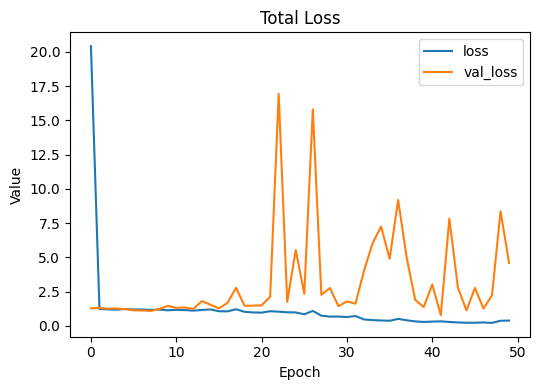

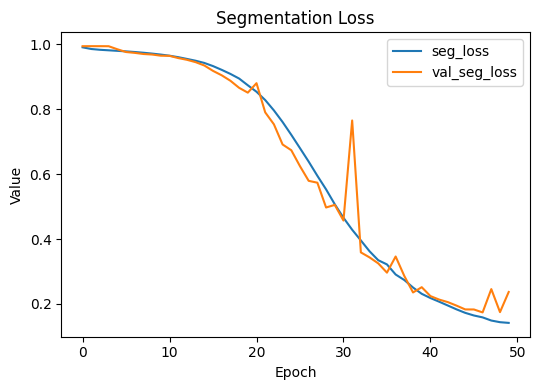

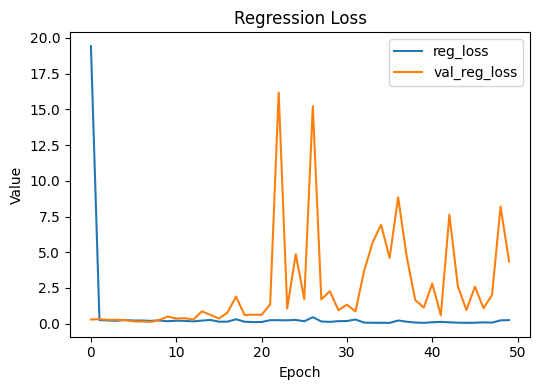

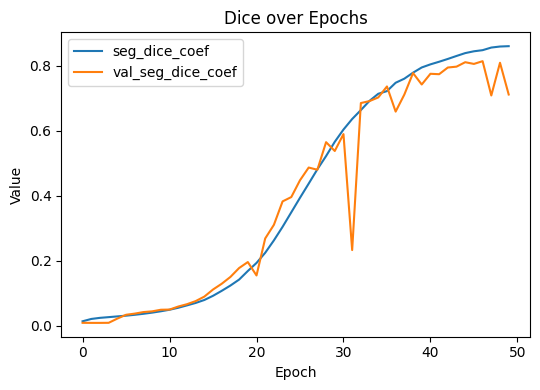

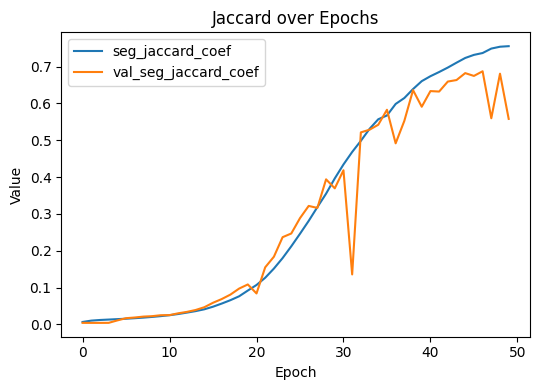

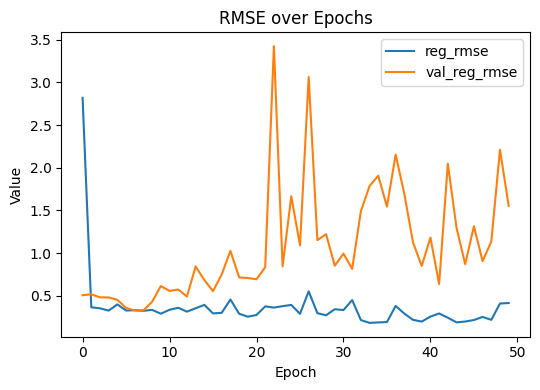

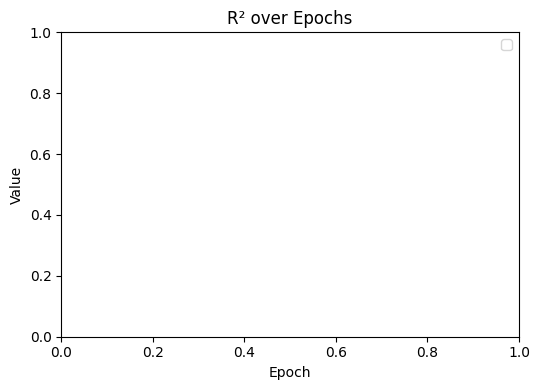

In [20]:
# keys depend on your compile(); these are typical with our setup:
# 'loss','val_loss','seg_loss','val_seg_loss','reg_loss','val_reg_loss',
# 'seg_dice_coef','val_seg_dice_coef','seg_jaccard_coef','val_seg_jaccard_coef',
# 'reg_rmse','val_reg_rmse','reg_r2_score','val_reg_r2_score'

hist = history.history

def plot_curve(keys, title, fname):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5.5,4))
    for k in keys:
        if k in hist: plt.plot(hist[k], label=k)
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel("Value"); plt.legend()
    plt.tight_layout()


# total loss
plot_curve(["loss","val_loss"], "Total Loss", "loss_total.png")

# task losses
plot_curve(["seg_loss","val_seg_loss"], "Segmentation Loss", "loss_seg.png")
plot_curve(["reg_loss","val_reg_loss"], "Regression Loss", "loss_reg.png")

# segmentation metrics
plot_curve(["seg_dice_coef","val_seg_dice_coef"], "Dice over Epochs", "metric_dice.png")
plot_curve(["seg_jaccard_coef","val_seg_jaccard_coef"], "Jaccard over Epochs", "metric_jaccard.png")

# regression metrics
plot_curve(["reg_rmse","val_reg_rmse"], "RMSE over Epochs", "metric_rmse.png")
plot_curve(["reg_r2_score","val_reg_r2_score"], "R² over Epochs", "metric_r2.png")


In [21]:
import os
import pandas as pd

label_dir = "Final_tvt_Dataset/test/labels"
csv_path  = "/content/strat_subset.csv"

# 1) CSV with ID_num extracted: OAS1_0179_MR1 -> 0179
df = pd.read_csv(csv_path)
df["ID_num"] = df["ID"].str.split("_").str[1]

# 2) Label IDs from filenames (strip .nii/.nii.gz)
label_files = [f for f in os.listdir(label_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
label_ids = [f.split(".nii")[0] for f in label_files]   # yields '0179' etc.
label_ids_set = set(label_ids)

# 3) Filter CSV to only rows that have a label in train
test_csv = df[df["ID_num"].isin(label_ids_set)].copy()

print("All CSV unique ID_num:", df["ID_num"].nunique())
print("Train label IDs:", len(label_ids_set))
print("Filtered train_csv unique ID_num:", test_csv["ID_num"].nunique())
print("Filtered train_csv rows:", len(test_csv))

# 4) (Optional) Deduplicate to one row per subject id (keep MR1 if present, else first)
# This keeps a single row per ID_num so it aligns 1:1 with labels.
test_csv["_mr"] = df["ID"].str.split("_").str[-1]  # MR1/MR2
test_csv = (test_csv.sort_values(["ID_num", "_mr"])  # MR1 sorts before MR2
                      .drop_duplicates(subset="ID_num", keep="first")
                      .drop(columns=["_mr"]))

print("After dedupe -> one row per subject:")
print("  train_csv unique ID_num:", test_csv["ID_num"].nunique())
print("  rows:", len(test_csv))

# 5) Sanity check: the sets should now match (or show what's missing)
csv_ids = set(test_csv["ID_num"])
print("CSV minus labels (should be empty):", csv_ids - label_ids_set)
print("Labels minus CSV (should be empty):", label_ids_set - csv_ids)


All CSV unique ID_num: 104
Train label IDs: 11
Filtered train_csv unique ID_num: 11
Filtered train_csv rows: 11
After dedupe -> one row per subject:
  train_csv unique ID_num: 11
  rows: 11
CSV minus labels (should be empty): set()
Labels minus CSV (should be empty): set()


In [ ]:
test_csv

,ID,M/F,Hand,Age,MMSE,CDR,eTIV,nWBV,ASF,Age_cat,ID_num
3,OAS1_0032_MR1,M,R,89,28.0,0.0,1631,0.682,1.076,4,0032
33,OAS1_0071_MR1,F,R,49,30.0,0.0,1459,0.808,1.203,2,0071
74,OAS1_0076_MR1,F,R,18,29.4,0.0,1501,0.839,1.169,1,0076
79,OAS1_0086_MR1,F,R,47,30.0,0.0,1311,0.835,1.339,2,0086
64,OAS1_0130_MR1,M,R,68,26.0,0.0,1444,0.789,1.216,3,0130
62,OAS1_0145_MR1,M,R,34,29.4,0.0,1653,0.831,1.062,2,0145
89,OAS1_0160_MR1,M,R,57,29.0,0.0,1745,0.813,1.006,3,0160
69,OAS1_0302_MR1,M,R,22,29.4,0.0,1570,0.831,1.118,1,0302
92,OAS1_0355_MR1,F,R,73,29.0,0.0,1123,0.790,1.563,3,0355
46,OAS1_0387_MR1,F,R,26,29.4,0.0,1149,0.851,1.527,1,0387


In [22]:
# test dataset
test_ds = make_multimodal_dataset(
    "Final_tvt_Dataset/test/images",
    "Final_tvt_Dataset/test/labels",
    test_csv,               # your filtered/encoded CSV with ID_num + features
    feature_cols,           # same features used for train/val
    batch_size=1,
    shuffle=False
)


In [23]:
import os, numpy as np, pandas as pd, nibabel as nib, matplotlib.pyplot as plt

# ---- NumPy metrics (binary masks expected) ----
def dice_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    inter = np.sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def jaccard_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

def test_and_save_multimodal(
    model,
    test_pairs,                      # list of (img_path, lbl_path)
    df_features,                     # DataFrame with columns: ID_num, feature_cols..., target_col
    feature_cols,                    # list of tabular feature names
    target_col="CDR",
    out_dir="generated",
    threshold=0.5
):
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(os.path.join(out_dir, "overlays"), exist_ok=True)

    # index by ID_num for fast lookup
    df_idx = df_features.set_index("ID_num")

    dice_scores, jaccard_scores = [], []
    y_true_reg, y_pred_reg = [], []

    for img_path, lbl_path in test_pairs:
        # ----- subject id extraction: mri_0012.nii -> 0012 -----
        base = os.path.basename(img_path)
        sid  = base.split(".nii")[0].replace("mri_", "")

        # ----- load volumes -----
        img = nib.load(img_path).get_fdata().astype(np.float32)
        lbl_nii = nib.load(lbl_path)
        lbl = lbl_nii.get_fdata().astype(np.float32)
        lbl = (lbl > 0.5).astype(np.float32)

        # normalize image
        img = (img - img.mean()) / (img.std() + 1e-8)

        # inputs
        img_in = img[np.newaxis, ..., np.newaxis]  # (1,D,H,W,1)
        feats  = df_idx.loc[sid, feature_cols].to_numpy().astype(np.float32)[np.newaxis, :]  # (1,F)
        targ   = float(df_idx.loc[sid, target_col])

        # ----- predict (segmentation + regression) -----
        pred_outputs = model.predict({"img_input": img_in, "tab_input": feats}, verbose=0)
        # pred_outputs is [seg_pred, reg_pred]
        seg_pred = pred_outputs[0][0, ..., 0]   # (D,H,W)
        reg_pred = float(pred_outputs[1][0, 0])

        pred_bin = (seg_pred > threshold).astype(np.float32)

        # ----- seg metrics -----
        dice = dice_coef_np(lbl, pred_bin)
        jaccard = jaccard_coef_np(lbl, pred_bin)
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)

        # ----- regression collect -----
        y_true_reg.append(targ)
        y_pred_reg.append(reg_pred)

        # ----- save predicted mask as NIfTI with GT affine/header -----
        pred_nii = nib.Nifti1Image(pred_bin.astype(np.uint8), affine=lbl_nii.affine, header=lbl_nii.header)
        nib.save(pred_nii, os.path.join(out_dir, f"{sid}_pred.nii"))

        # ----- overlay figure (mid axial) -----
        mid = img.shape[2] // 2
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(img[:, :, mid], cmap="gray")
        plt.imshow(lbl[:, :, mid], alpha=0.4, cmap="Reds")
        plt.title(f"GT {sid}"); plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(img[:, :, mid], cmap="gray")
        plt.imshow(pred_bin[:, :, mid], alpha=0.4, cmap="Oranges")
        plt.title(f"Pred {sid} (Dice {dice:.3f}, IoU {jaccard:.3f})"); plt.axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "overlays", f"{sid}_overlay.png"), dpi=140)
        plt.close()

    # ----- aggregates -----
    mean_dice = float(np.mean(dice_scores)) if dice_scores else float("nan")
    mean_iou  = float(np.mean(jaccard_scores)) if jaccard_scores else float("nan")

    y_true_reg = np.array(y_true_reg, dtype=np.float32)
    y_pred_reg = np.array(y_pred_reg, dtype=np.float32)
    rmse = float(np.sqrt(np.mean((y_true_reg - y_pred_reg) ** 2)))
    ssr  = float(np.sum((y_true_reg - y_pred_reg) ** 2))
    sst  = float(np.sum((y_true_reg - np.mean(y_true_reg)) ** 2)) + 1e-8
    r2   = float(1.0 - ssr / sst)

    # ----- regression scatter -----
    plt.figure(figsize=(5,5))
    plt.scatter(y_true_reg, y_pred_reg, s=18)
    lims = [min(y_true_reg.min(), y_pred_reg.min()), max(y_true_reg.max(), y_pred_reg.max())]
    plt.plot(lims, lims, linestyle="--")
    plt.xlabel("Actual CDR"); plt.ylabel("Predicted CDR")
    plt.title(f"RMSE={rmse:.3f}  R²={r2:.3f}")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "cdr_pred_vs_actual.png"), dpi=150)
    plt.close()

    print(f"✔ Tested {len(test_pairs)} subjects")
    print(f"Mean Dice:    {mean_dice:.4f}")
    print(f"Mean Jaccard: {mean_iou:.4f}")
    print(f"Regression RMSE: {rmse:.4f} | R²: {r2:.4f}")

    return {
        "n": len(test_pairs),
        "mean_dice": mean_dice,
        "mean_jaccard": mean_iou,
        "rmse": rmse,
        "r2": r2
    }


In [24]:
# Build (img_path, lbl_path) pairs for the test split
test_img_dir = "Final_tvt_Dataset/test/images"
test_lbl_dir = "Final_tvt_Dataset/test/labels"

test_img_paths = sorted([os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.startswith("mri_") and f.endswith(".nii") or f.endswith(".nii.gz")])
test_pairs = []
for ip in test_img_paths:
    sid = os.path.basename(ip).split(".nii")[0].replace("mri_", "")
    lp  = os.path.join(test_lbl_dir, f"{sid}.nii")
    if not os.path.exists(lp):
        lp = os.path.join(test_lbl_dir, f"{sid}.nii.gz")
    if os.path.exists(lp):
        test_pairs.append((ip, lp))

# df_test should be your preprocessed/filtered test CSV with ID_num and feature columns you chose
# feature_cols = ["Age","MMSE","eTIV","nWBV","ASF"]   # example
# model = ... (your trained multimodal UNet+regression model)

results = test_and_save_multimodal(
    model=model,
    test_pairs=test_pairs,
    df_features=test_csv,      # must contain columns: ID_num + feature_cols + target_col
    feature_cols=feature_cols,
    target_col="CDR",
    out_dir="generated_test",
    threshold=0.5
)
print(results)


✔ Tested 11 subjects
Mean Dice:    0.6878
Mean Jaccard: 0.5376
Regression RMSE: 1.7264 | R²: -143.2621
{'n': 11, 'mean_dice': 0.6878228783607483, 'mean_jaccard': 0.5376191735267639, 'rmse': 1.7264477014541626, 'r2': -143.26208835025665}


In [25]:
from google.colab import files
import shutil


def zip_and_download(folder_path, zip_name=None):

    if zip_name is None:
        zip_name = folder_path.rstrip("/")

    shutil.make_archive(zip_name, 'zip', folder_path)
    files.download(f"{zip_name}.zip")

In [26]:
zip_and_download("generated_test", zip_name="generated_test")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>